In [1]:
import torch
import IPython.display as ipd
# from Prop import Prop
# from Prop_mixture import Prop_mixture
# from Baseline_new import Baseline_new
from Baseline_0105_Ks import Baseline_0105
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from Blocks import BasicBlock, Bottleneck, ChannelChange, Bottleneck_new
import os
import librosa
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

/media/sdb1/hy17/venv/lib/python3.6/site-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:

# model_oldsr = torch.load('../Final_Models/0513_230921ratio_sr32_d6_5db.model') 
# model_oldsr = torch.load('../Final_Models/0513_221509ratio_sr32_d6_5db.model')
# model_newsr = torch.load('Final_Models/0602_123426ratio_sr24_d6_5db.model')
# model_newNonSR = torch.load('0617_175014_24_d6_5db.model')
# # model_newprop = torch.load('Final_Models/0602_123426ratio_sr24_d6_5db.model')
# # model_newbase = torch.load('0606_214529_baseline_sr32_d3_5db.model')

# model1 = torch.load('/media/sdb1/hy17/Projects/SANAC_backup/SANAC/Final_Models/0511_025544_sr32_d3.model')
# model_24 = torch.load('../Final_Models/0602_022246ratio_sr24_d6_0db.model')
# model_24_base = torch.load('/media/sdb1/hy17/Projects/SANAC_backup/SANAC/Final_Models/0510_142628_baseline_sr32_d3.model')
# model_16 = torch.load('/media/sdb1/hy17/Projects/SANAC_backup/SANAC/Final_Models/0509_sr8_d3.model')
# model_16_base = torch.load('/media/sdb1/hy17/Projects/SANAC_backup/SANAC/Final_Models/0511_023814_baseline_sr16_d3.model')
# model_8 = torch.load('/media/sdb1/hy17/Projects/SANAC_backup/SANAC/Final_Models/0511_131846_s16_d3.model')
# model_8_base = torch.load('/media/sdb1/hy17/Projects/SANAC_backup/SANAC/Final_Models/0513_133044_baseline_sr32_d3_0db.model')
# model_8_base = torch.load('/media/sdb1/hy17/Projects/SANAC_backup/SANAC/Final_Models/0511_141723_baseline_sr16_d3.model')

# model_base_sr = torch.load('../models/1109_155434_32_d6_0db_Base_stage0.model')
# model_base = torch.load('../models/1109_215511_32_d6_0db_Base_stage0.model')

# model_stage0 = torch.load('../models/1117_114314_32_d6_0db_Base.model')

# model_ept0 = torch.load('../models/1110_101415_32_d6_0db_Prop_stage1ept0.model')


In [121]:
def load_trim(wavpath, n, db=0, overlap=64, window_in_data = False):
    
    window = np.hanning(overlap*2-1) 
    window = np.concatenate((window[:overlap],np.ones(512-overlap*2),window[overlap-1:]))
    window = window.reshape(1,-1)
    window = window.astype(np.float32)
    
    max_x = 31.61
    
    try:
        c, cr = librosa.load(wavpath, sr = None)
        c /= np.std(c)
    except OSError:
        print('errorfile:',wavpath)
    
    n = n[len(n)//2:len(n)//2+len(c)]        
        
    scalar = 10.0 ** (0.05 * (db))
    n /= np.std(n)* scalar
        
#     n /= max(abs(c))
#     c /= max(abs(c))
    x = c + n
    
    c_l = []
    x_l = []
    
    for i in range(0, len(c), 512 - overlap):
        if i + 512 > len(c):
            break
        c_l.append(c[i:i+512])
        x_l.append(x[i:i+512])
    c_l = np.array(c_l)
    x_l = np.array(x_l)
    c = c[:len(c_l)*(512-overlap)+overlap]
    x = x[:len(c)]
    
    if window_in_data:
        c_l = c_l * window
        x_l = x_l * window

    return c/max_x, x/max_x, c_l/max_x, x_l/max_x


def load_trim_clean(wavpath, overlap=64, window_in_data = False):
    
    window = np.hanning(overlap*2-1) 
    window = np.concatenate((window[:overlap],np.ones(512-overlap*2),window[overlap-1:]))
    window = window.reshape(1,-1)
    window = window.astype(np.float32)
    
    max_c = 22.5455
    
    try:
        c, cr = librosa.load(wavpath, sr = None)
        c /= np.std(c)
    except OSError:
        print('errorfile:',wavpath)
    
    c_l = []
    
    for i in range(0, len(c), 512 - overlap):
        if i + 512 > len(c):
            break
        c_l.append(c[i:i+512])
    c_l = np.array(c_l)
    c = c[:len(c_l)*(512-overlap)+overlap]
    
    if window_in_data:
        c_l = c_l * window

    return c/max_c, c_l/max_c

def rebuild(output, overlap = 64):
    
    output = output.detach().cpu().data.numpy()
    len_wav = len(output) * (512 - overlap) + overlap
    wave = torch.zeros(len_wav)

    for i in range(len(output)):
        wave[i*(512-overlap):i*(512-overlap)+512] += output[i]       
    
    return wave

def rebuild_window(output, overlap = 64):
    output = output.detach().cpu().data.numpy() # shape - (bt, 512)
    len_wav = len(output) * (512 - overlap) + overlap
    
    window = np.hanning(overlap*2-1) 
    window = np.concatenate((window[:overlap],np.ones(512-overlap*2),window[overlap-1:]))
    window = window.reshape(1,-1)
    window = window.astype(np.float32)
#     window = np.hamming(overlap*2) 
#     window = np.concatenate((window[:overlap],np.ones(512-overlap*2),window[overlap:]))
#     window = window.reshape(1,-1)
#     window = window.astype(np.float32)
    output *= window
    wave = torch.zeros(len_wav)
    for i in range(len(output)):
#         print(i)
        wave[i*(512-overlap):i*(512-overlap)+512] += output[i] 
    
    return wave

def SDR(s, sr): # input (50, 512), (50, 512)
    
    eps=1e-20
    s = s.cpu().data.numpy()
    sr = sr.cpu().data.numpy()
    sdr = 10*np.log10(np.sum(s**2)/(np.sum((s-sr)**2)+eps)+eps)
    
    return sdr

def SISDR(s,sr,  cuda = False):
    
    eps = 1e-20
    scale = torch.sum(sr * s, dim = 1) / torch.sum(s**2, dim = 1) 
    scale = scale.unsqueeze(dim = 1) # shape - [50,1]
    s = s * scale
    sisdr = torch.mean(10*torch.log10(torch.sum(s**2, dim = 1)/(torch.sum((s-sr)**2, dim=1)+eps)+eps))
    if cuda:
        return torch.mean(sisdr)
    else:
        return torch.mean(sisdr).cpu().data.numpy()
    
import collections
def entropy(arg):
    entropy = 0
    counter = collections.Counter(arg)
    sum_v = sum(counter.values())
    for value in counter.values():
        p = value / sum_v
        entropy += - np.log(p)*p
    return entropy


In [122]:
def gen_sound(i=0,db=0, window_in_data=False):
    wavpath0 = '/media/sdc1/Data/timit-wav/test/dr5/mrws1/sx140.wav'
    wavpath1 = '/media/sdc1/Data/timit-wav/test/dr1/faks0/sa1.wav'
    wavpath2 = '/media/sdc1/Data/timit-wav/test/dr1/mreb0/sa2.wav'
    wavpath3 = '/media/sdc1/Data/timit-wav/test/dr3/mkch0/sx28.wav'
    wavpath4 = '/media/sdc1/Data/timit-wav/test/dr3/fkms0/sx50.wav'
    wavpath5 = '/media/sdc1/Data/timit-wav/test/dr5/fjcs0/sx139.wav'
    wavpath6 = '/media/sdc1/Data/timit-wav/test/dr4/fsem0/sx28.wav'
    wavpath7 = '/media/sdc1/Data/timit-wav/test/dr4/mkcl0/sx191.wav'
    wavpath8 = '/media/sdc1/Data/timit-wav/test/dr6/flnh0/sx134.wav'
    wavpath9 = '/media/sdc1/Data/timit-wav/test/dr6/mesd0/sx12.wav'

    path_name = [wavpath0, wavpath1, wavpath2,wavpath3,wavpath4,wavpath5,wavpath6,wavpath7,wavpath8,wavpath9]
    # n_idx = [2, -1, -3, -4, 5, 1]

    # idx = 4
    names = ['birds', 'computerkeyboard', 'jungle', 'ocean', 'casino', 'eatingchips', 'machineguns',\
                     'cicadas', 'frogs', 'motorcycles']
#     i = 1
    path = path_name[i]
    noise_path = '/media/sdc1/Data/Duan/{}.wav'.format(names[i])
    n, nr = librosa.load(noise_path, sr=None)
    # tes, sr = librosa.load(wavpath5, sr=None)

#     db = 5
    c, x, c_l, x_l = load_trim(path, n, db=db, window_in_data=window_in_data)

    c_l = torch.Tensor(c_l)
#     c = torch.Tensor(c)
    x_l = torch.Tensor(x_l)
    #         x = torch.Tensor(x)
    
    return c, x, c_l, x_l

In [123]:
def gen_clean_sound(i=0,window_in_data=False):
    wavpath0 = '/media/sdc1/Data/timit-wav/test/dr5/mrws1/sx140.wav'
    wavpath1 = '/media/sdc1/Data/timit-wav/test/dr1/faks0/sa1.wav'
    wavpath2 = '/media/sdc1/Data/timit-wav/test/dr1/mreb0/sa2.wav'
    wavpath3 = '/media/sdc1/Data/timit-wav/test/dr3/mkch0/sx28.wav'
    wavpath4 = '/media/sdc1/Data/timit-wav/test/dr3/fkms0/sx50.wav'
    wavpath5 = '/media/sdc1/Data/timit-wav/test/dr5/fjcs0/sx139.wav'
    wavpath6 = '/media/sdc1/Data/timit-wav/test/dr4/fsem0/sx28.wav'
    wavpath7 = '/media/sdc1/Data/timit-wav/test/dr4/mkcl0/sx191.wav'
    wavpath8 = '/media/sdc1/Data/timit-wav/test/dr6/flnh0/sx134.wav'
    wavpath9 = '/media/sdc1/Data/timit-wav/test/dr6/mesd0/sx12.wav'

    path_name = [wavpath0, wavpath1, wavpath2,wavpath3,wavpath4,wavpath5,wavpath6,wavpath7,wavpath8,wavpath9]
    path = path_name[i]
    
    c, c_l = load_trim_clean(path, window_in_data=window_in_data)

    c_l = torch.Tensor(c_l)
    
    return c, c_l

In [258]:
def generate_result(model, x_l, window_in_data):
    model.eval()
    n_h = None
#     s_h, n_h, prob_s, prob_n = model(x_l.cuda(),soft = False)
    output = model(x_l.cuda(),soft = True)
    
    if window_in_data:
        rebuild_f = rebuild
    else:
        rebuild_f = rebuild_window
        
    s_h = output[0]
    if len(output) == 4:
        n_h = output[1]        
        
    rs = rebuild_f(s_h).cpu().data.numpy()
    if not isinstance(n_h, type(None)):
        rx = rebuild_f(s_h+n_h).cpu().data.numpy()
    else:
        rx = rs
    
    return rs, rx

**Old SR**

In [262]:
window_in_data = False
# model_1= torch.load('../models/1221_190850_32_d1_0db_Base.model') # noSR
# model_2= torch.load('../models/1221_192143_32_d3_0db_Base_stage1ept0.model') # noSR

# model_2 = torch.load('../models/1220_193421_32_d6_0db_Prop.model') # SR

# model2_0 = torch.load('../models/0106_125430_32_d3__Base_stage0.model') # noSR mixture
# model2_1 = torch.load('../models/0106_125430_32_d3__Base_stage1ept0.model')
# model2_2 = torch.load('../models/0106_125430_32_d3__Base.model')
model = torch.load('../models/0111_145001_32_d1__Base_epoch11.model')

# model = torch.load('../models/0110_164906_32_d1__Base_epoch20.model')

In [263]:
# c, x, c_l, x_l = gen_sound(i=1, db=0, window_in_data=window_in_data)
# ipd.Audio(x/max(x), rate = 16000)
c, c_l = gen_clean_sound(i=1, window_in_data=window_in_data)
ipd.Audio(c/max(c), rate = 16000)
# sf.write('../testuttr/uttr1_original.wav',  x/max(x), 16000, 'PCM_24')
# librosa.output.write_wav('../testuttr/uttr1_original.wav', x/max(x), 16000)

In [264]:
rs1, rx1 = generate_result(model, c_l, window_in_data=window_in_data)
# import soundfile as sf
# sf.write('../testuttr/uttr1_base_final_noSR.wav',  rx1/max(rx1), 16000, 'PCM_24')
# librosa.output.write_wav('../testuttr/uttr1_stage0.wav',)
ipd.Audio(rx1/max(abs(rx1)), rate = 16000)

In [249]:
import librosa
from matplotlib import pyplot as plt
RX = 20*np.log(abs(librosa.stft(rx1, n_fft=512)))
C = 20*np.log(abs(librosa.stft(c, n_fft=512)))

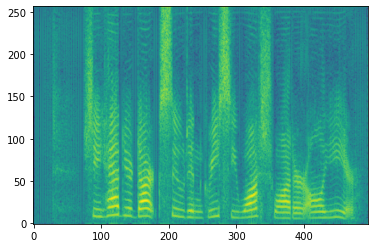

In [250]:
plt.imshow(RX, origin='lower', aspect='auto')

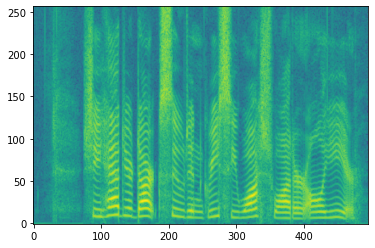

In [251]:
plt.imshow(C, origin='lower', aspect='auto')

In [119]:
rs1=rebuild(c_l)

(141, 512)
torch.Size([512])


In [120]:
ipd.Audio(rs1/max(abs(rs1)), rate = 16000)

In [39]:
model.scale

1000

In [40]:
s_h, _ = model(c_l.cuda(), soft=False)
s_h = s_h[:,0,:]

In [41]:
import torchaudio
def melMSELoss_short(s, sr, n_mels = [8, 16, 32, 128]): 
    
    assert s.shape[1] == 512
    assert sr.shape[1] == 512
    loss = 0
    eps = 1e-20
    mse = nn.MSELoss().cuda()
    s = s.cuda()
    sr = sr.cuda()
    for n in n_mels:
        melspec = torchaudio.transforms.MelSpectrogram(n_fft=512, n_mels=n).cuda() 
        s_mel = melspec(s)[:,:,1] # shape - [bt, n]
        sr_mel = melspec(sr)[:,:,1]
        
        # s_mel.shape -> [bt, n]
        
        s_mel = torch.log(s_mel + eps)
        sr_mel = torch.log(sr_mel + eps)
        error = mse(s_mel, sr_mel)/len(s_mel)
#         m = mse(s_mel, sr_mel)
        loss += error
#         print(error)
    return loss/len(n_mels)  

In [42]:
melMSELoss_short(s_h, c_l)

tensor(0.1169, device='cuda:0', grad_fn=<DivBackward0>)

In [31]:
melMSELoss_short(, c_l)

tensor(0., device='cuda:0')

In [43]:
rx1 = torch.tensor(rx1)
# x = torch.tensor(x)
# SDR(rx1, x)

c = torch.tensor(c)
SDR(rx1, c)

10.95555508988796

In [12]:
from matplotlib import pyplot as plt
plt.plot(c)
plt.show()

<Figure size 640x480 with 1 Axes>

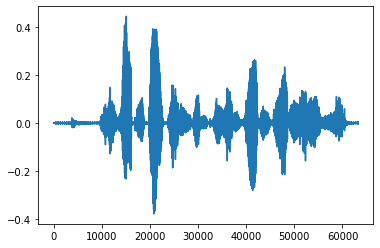

In [13]:
plt.plot(rx1)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

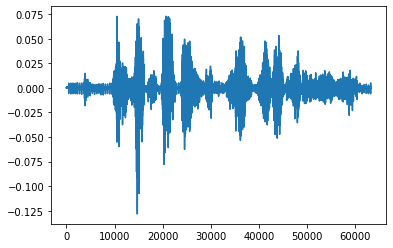

In [14]:
plt.plot(c-rx1)
plt.show

In [15]:
model.means

tensor([[-1.2062, -1.2062, -1.2062, -1.2062, -1.2062, -1.2062, -1.2062, -1.2062,
         -1.2062, -1.2062, -1.0376, -0.9405, -0.8281, -0.6494, -0.4379, -0.1937,
          0.0502,  0.2787,  0.4797,  0.6473,  0.7814,  0.8860,  0.9540,  1.0252,
          1.1908,  1.2030,  1.2031,  1.2031,  1.2031,  1.2031,  1.2031,  1.2031]],
       device='cuda:0', requires_grad=True)

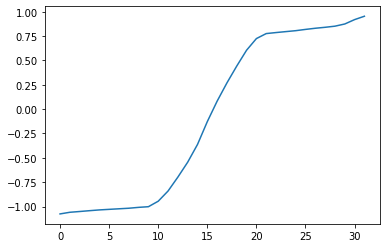

In [41]:
from matplotlib import pyplot as plt
plt.plot(model.means.cpu().data.numpy()[0])
plt.show()

In [9]:
c_l.shape

torch.Size([141, 512])

In [115]:
s_h, prob = model(c_l.cuda(), soft = True)

In [116]:
loss_qtz = torch.mean(torch.sum(torch.sqrt(prob+1e-20), -1) - 1) 

In [117]:
loss_qtz

tensor(0.0496, device='cuda:0', grad_fn=<MeanBackward0>)

In [48]:
y = F.softmax(x*100)

/media/sdb1/hy17/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [49]:
torch.mean(torch.sum(torch.sqrt(y+1e-20), -1) - 1) 

tensor(0.0222, device='cuda:0', grad_fn=<MeanBackward0>)

In [63]:
def get_n_params(model):
    count = 0
    for param in list(model.parameters()):
        nn = 1
        for s in list(param.size()):
            nn = nn*s
        count += nn
    return count
get_n_params(model)

422442

In [66]:
params = model.state_dict()

In [75]:
for items in params:
    print(items, params[items].shape)

enc_base.0.weight torch.Size([100, 1, 9])
enc_base.0.bias torch.Size([100])
enc_base.2.conv_in.weight torch.Size([25, 100, 9])
enc_base.2.conv_in.bias torch.Size([25])
enc_base.2.conv_bt.weight torch.Size([25, 25, 9])
enc_base.2.conv_bt.bias torch.Size([25])
enc_base.2.conv_out.weight torch.Size([100, 25, 9])
enc_base.2.conv_out.bias torch.Size([100])
enc_base.3.conv_in.weight torch.Size([25, 100, 9])
enc_base.3.conv_in.bias torch.Size([25])
enc_base.3.conv_bt.weight torch.Size([25, 25, 9])
enc_base.3.conv_bt.bias torch.Size([25])
enc_base.3.conv_out.weight torch.Size([100, 25, 9])
enc_base.3.conv_out.bias torch.Size([100])
enc_base.4.weight torch.Size([100, 100, 9])
enc_base.4.bias torch.Size([100])
enc_base.6.conv_in.weight torch.Size([25, 100, 9])
enc_base.6.conv_in.bias torch.Size([25])
enc_base.6.conv_bt.weight torch.Size([25, 25, 9])
enc_base.6.conv_bt.bias torch.Size([25])
enc_base.6.conv_out.weight torch.Size([100, 25, 9])
enc_base.6.conv_out.bias torch.Size([100])
enc_base.7.c

In [168]:
window = np.hanning(overlap*2-1) 
window = np.concatenate((window[:overlap],np.ones(64-overlap*2),window[overlap-1:]))
window = window.reshape(1,-1)
window = window.astype(np.float32)

print(window.shape)
wave = torch.zeros(640)
for i in range(len(wave)//32-1):
    wave[i*(64-overlap):i*(64-overlap)+64] += window

(1, 64)


In [169]:
wave

tensor([0.0000, 0.0026, 0.0102, 0.0229, 0.0405, 0.0628, 0.0896, 0.1206, 0.1555,
        0.1939, 0.2355, 0.2798, 0.3263, 0.3747, 0.4243, 0.4747, 0.5253, 0.5757,
        0.6253, 0.6737, 0.7202, 0.7645, 0.8061, 0.8445, 0.8794, 0.9104, 0.9372,
        0.9595, 0.9771, 0.9898, 0.9974, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [136]:
window=window[0]

In [139]:
window[:overlap]+window[512-overlap-1:]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [141]:
window[:overlap].shape

(32,)

In [121]:
window2 = np.hanning(overlap*2)

In [122]:
window2

array([0.        , 0.00248461, 0.00991376, 0.0222136 , 0.03926189,
       0.06088921, 0.08688061, 0.11697778, 0.15088159, 0.1882551 ,
       0.22872687, 0.27189467, 0.31732949, 0.36457977, 0.41317591,
       0.46263495, 0.51246535, 0.56217185, 0.61126047, 0.65924333,
       0.70564355, 0.75      , 0.79187184, 0.83084292, 0.86652594,
       0.89856625, 0.92664544, 0.95048443, 0.96984631, 0.98453864,
       0.99441541, 0.99937846, 0.99937846, 0.99441541, 0.98453864,
       0.96984631, 0.95048443, 0.92664544, 0.89856625, 0.86652594,
       0.83084292, 0.79187184, 0.75      , 0.70564355, 0.65924333,
       0.61126047, 0.56217185, 0.51246535, 0.46263495, 0.41317591,
       0.36457977, 0.31732949, 0.27189467, 0.22872687, 0.1882551 ,
       0.15088159, 0.11697778, 0.08688061, 0.06088921, 0.03926189,
       0.0222136 , 0.00991376, 0.00248461, 0.        ])

In [103]:
len(window[:32])

32

In [102]:
len(window[32:])

32

In [134]:
window[:32] + window[512-32:-1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [66]:
window[512-overlap:] + window[:overlap]

array([1.0794282, 1.0771481, 1.0748962, 1.0726951, 1.0705667, 1.0685319,
       1.066611 , 1.0648234, 1.0631865, 1.0617168, 1.0604287, 1.0593352,
       1.058447 , 1.057773 , 1.05732  , 1.0570923, 1.0570923, 1.05732  ,
       1.057773 , 1.058447 , 1.0593352, 1.0604287, 1.0617168, 1.0631865,
       1.0648234, 1.066611 , 1.0685319, 1.0705667, 1.0726951, 1.0748962,
       1.0771481, 1.0794282], dtype=float32)

In [71]:
np.hanning(64)

array([0.        , 0.00248461, 0.00991376, 0.0222136 , 0.03926189,
       0.06088921, 0.08688061, 0.11697778, 0.15088159, 0.1882551 ,
       0.22872687, 0.27189467, 0.31732949, 0.36457977, 0.41317591,
       0.46263495, 0.51246535, 0.56217185, 0.61126047, 0.65924333,
       0.70564355, 0.75      , 0.79187184, 0.83084292, 0.86652594,
       0.89856625, 0.92664544, 0.95048443, 0.96984631, 0.98453864,
       0.99441541, 0.99937846, 0.99937846, 0.99441541, 0.98453864,
       0.96984631, 0.95048443, 0.92664544, 0.89856625, 0.86652594,
       0.83084292, 0.79187184, 0.75      , 0.70564355, 0.65924333,
       0.61126047, 0.56217185, 0.51246535, 0.46263495, 0.41317591,
       0.36457977, 0.31732949, 0.27189467, 0.22872687, 0.1882551 ,
       0.15088159, 0.11697778, 0.08688061, 0.06088921, 0.03926189,
       0.0222136 , 0.00991376, 0.00248461, 0.        ])